In [4]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=193b8b21a0a013a7fdc988152c3eea087ec1531de9d3036379dfd46dbdab2482
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=5de876e737b2dc2aa2e20577016453cf4ed8e0b0583598c5cd7a55fc9bdd784e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import os
import matplotlib.pylab as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [120]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = path = '/kaggle/working/' 
MODEL_PATH = '/kaggle/input/unet/pytorch/unet_model_70/1/UNET_model_70_t.pt'
TRAIN_IMG_PATH = '/kaggle/input/ct-scans-ds/train_ds/original_png'
TRAIN_MASK_PATH = '/kaggle/input/ct-scans-ds/train_ds/mask_png'
TEST_IMG_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/original_png'
TEST_MASK_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/mask_png'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LEARNING_RATE = 1e-2
NUM_EPOCHS = 120
BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False


In [121]:
DEVICE

device(type='cuda')

In [122]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
    
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
    
        return self.final_conv(x)
        

In [123]:
class CTDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.image_path))

    def __getitem__(self, index):
        img_name = f'{index}.png'
        img_path = os.path.join(self.image_path, img_name)
        mask_path = os.path.join(self.mask_path, img_name)  # Assuming mask files have the same name as image files with "_mask" suffix

        image = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0
        image = image / 255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [124]:
train_transform = A.Compose(
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
#         A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ]
)                                           

In [125]:
def save_checkpoint(state, path=PATH, filename="model.pt"):
    print("=> Saving checkpoint")
    torch.save(state, path + filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_path, train_mask_path, val_path, val_mask_path, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
    train_ds = CTDataset(image_path=train_path, mask_path=train_mask_path, transform=train_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
    val_ds = CTDataset(image_path=val_path, mask_path=val_mask_path, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=batch_size,pin_memory=pin_memory, shuffle=False)
    return train_loader, val_loader

def check_accuracy(loader, model, history_val, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    recall = 0
    iou = 0
    precision = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():
        for x,y in tqdm(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            TP = ((y == 1) * (preds == 1)).sum()
            FP = ((y == 0) * (preds == 1)).sum()
            FN = ((y == 1) * (preds == 0)).sum()
            TN = ((y == 0) * (preds == 0)).sum()
            
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)
            precision += ((TP + 1e-8) / (TP + FP + 1e-8))
            recall += ((TP + 1e-8) / (TP + FN + 1e-8))
            iou += ((TP + 1e-8) / (TP + FP + FN + 1e-8))

    history_val['val_dice_coe'].append(dice_score/(len(loader)))
    history_val['val_precision'].append(precision/(len(loader)))
    history_val['val_recall'].append(recall/(len(loader)))
    history_val['val_iou'].append(iou/(len(loader)))
    
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)} ")
    model.train()

def save_predicts_as_imgs(loader, model, folder='saved_images\\', device="cuda"):
    model.eval()
    for idx, (x,y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{PATH + folder}pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{PATH + folder}{idx}.png")

    model.train()

In [133]:
def train_fn(loader, model, optimizer, loss_fn, scaler, history_val):
    loop = tqdm(loader)
    dice_score = 0
    iou = 0
    precision = 0
    recall = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        # with torch.cuda.amp.autocast():
        
        predictions = model(data)
        
#         predictions = torch.sigmoid(predictions)
        preds = (predictions > 0.5).float()
        
#         fig = plt.figure(figsize=(10, 20)) 
    
#         fig.add_subplot(1, 4, 1)
#         plt.imshow(data[0].cpu().T, cmap='gray')
# #         plt.axis('off')
#         plt.title('Input')

#         fig.add_subplot(1, 4, 2)
#         plt.imshow(targets[0].cpu().T, cmap='gray')
#         plt.axis('off')
#         plt.title('Mask')

#         fig.add_subplot(1, 4, 3)
#         plt.imshow((data+targets+preds)[0].cpu().T, cmap='gray')
#         plt.axis('off')
#         plt.title('Combined')


#         fig.add_subplot(1, 4, 4)
#         plt.imshow(preds[0].cpu().T, cmap='gray')
#         plt.axis('off')
#         plt.title('Preds')
        
        TP = ((preds == 1) * (targets == 1)).sum()
        FP = ((preds == 1) * (targets == 0)).sum()
        FN = ((preds == 0) * (targets == 1)).sum()
        TN = ((preds == 0) * (targets == 0)).sum()
        
        
        dice_score += (2 * (preds * targets).sum() + 1e-8) / ((preds + targets).sum() + 1e-8)
        precision += ((TP + 1e-8) / (TP + FP + 1e-8))
        recall += ((TP + 1e-8) / (TP + FN + 1e-8))
        iou += ((TP + 1e-8) / (TP + FP + FN + 1e-8))
        
        
        loss = loss_fn(predictions, targets)
        
        # backward
        optimizer.zero_grad()
        # loss = criterion(y_pred, mask)
        loss.backward()
        optimizer.step()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
#         break
#     history_val['val'].append(dice_score/(len(loader)))
    history_val['train_precision'].append(precision/(len(loader)))
    history_val['train_recall'].append(recall/(len(loader)))
    history_val['train_iou'].append(iou/(len(loader)))
    history_val['train_dice_coe'].append(dice_score/(len(loader)))
    

In [127]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        intersection = (predicted * target).sum()
        union = predicted.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

In [128]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        

    def forward(self, inputs, targets, smooth=1e-8):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
#         print(inputs.shape, targets.shape)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
#         print(BCE, dice_loss)
        return Dice_BCE

In [15]:
# model = UNET(in_channels=1, out_channels=1).to(device=DEVICE)
model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
#     activation='sigmoid',
).to(device=DEVICE)
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.5MB/s]


In [129]:
train_loader, val_loader = get_loaders(
    TRAIN_IMG_PATH,
    TRAIN_MASK_PATH,
    TEST_IMG_PATH,
    TEST_MASK_PATH,
    BATCH_SIZE,
    train_transform,
    val_transform
)

In [188]:
if LOAD_MODEL:
    load_checkpoint(torch.load(MODEL_PATH), model)

history_val = {'train_dice_coe':[], 'val_dice_coe':[], 'train_recall':[], 'train_precision':[], 'train_iou':[], 'val_precision':[], 'val_recall': [], 'val_iou': []}

check_accuracy(val_loader, model, history_val, device=DEVICE)

scaler = None
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, history_val)
    
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, history_val, device=DEVICE)

    #print some examples to a folder
#     save_predicts_as_imgs(val_loader, model, folder="saved_images\\", device=DEVICE)

100%|██████████| 17/17 [00:01<00:00,  9.49it/s]


Got 17290071/17301504 with acc 99.93
Dice score: 0.4051711857318878 


100%|██████████| 45/45 [00:11<00:00,  3.96it/s, loss=0.402] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00, 10.05it/s]


Got 17290717/17301504 with acc 99.94
Dice score: 0.4178837835788727 


100%|██████████| 45/45 [00:11<00:00,  3.94it/s, loss=0.0824]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


Got 17290517/17301504 with acc 99.94
Dice score: 0.4565465748310089 


100%|██████████| 45/45 [00:11<00:00,  3.81it/s, loss=0.0656]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.99it/s]


Got 17290517/17301504 with acc 99.94
Dice score: 0.38910990953445435 


 29%|██▉       | 13/45 [00:03<00:08,  3.70it/s, loss=0.0663]


KeyboardInterrupt: 

In [136]:
train_dice_val = [h.cpu() for h in history_val['train_dice_coe']]
val_dice_val = [h.cpu() for h in history_val['val_dice_coe']]
train_precision_val = [h.cpu() for h in history_val['train_precision']]
train_iou_val = [h.cpu() for h in history_val['train_iou']]
train_recall_val = [h.cpu() for h in history_val['train_recall']]
val_precision_val = [h.cpu() for h in history_val['val_precision']]
val_iou_val = [h.cpu() for h in history_val['val_iou']]
val_recall_val = [h.cpu() for h in history_val['val_recall']]

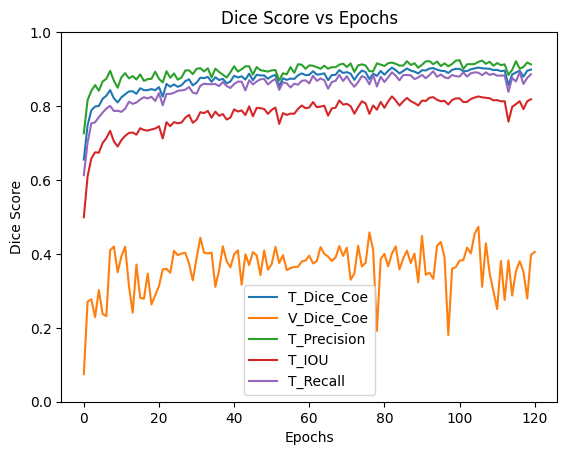

In [137]:
plt.plot(train_dice_val, label='T_Dice_Coe')
plt.plot(val_dice_val, label='V_Dice_Coe')
plt.plot(train_precision_val, label='T_Precision')
plt.plot(train_iou_val, label='T_IOU')
plt.plot(train_recall_val, label='T_Recall')
# plt.plot(val_precision_val)
# plt.plot(val_iou_val)
# plt.plot(val_recall_val)
plt.title('Dice Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [103]:
mask_one = Image.open(train_image_path + "0.png")
mask_one

NameError: name 'train_image_path' is not defined

tensor(0.2820, device='cuda:0')
torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
0.0 0.0 1.0 250.0
tensor(4.0000e-11, device='cuda:0')


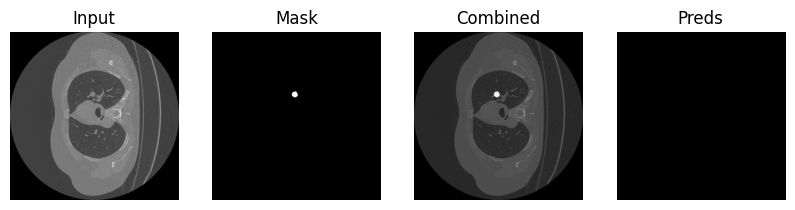

In [197]:
with torch.no_grad():
    model.eval()
    x = torch.tensor(np.array(Image.open(TEST_IMG_PATH + "/100.png").convert("L"), dtype=np.float32)).to(device=DEVICE) / 255
    y = torch.tensor(np.array(Image.open(TEST_MASK_PATH + "/100.png").convert("L"), dtype=np.float32)).to(device=DEVICE) / 255
#     x = (x > x.mean()*1.5) * x
    print(x.mean())
    x = x.reshape(1, 1, 512, 512)
    y = y.reshape(1, 1, 512, 512)
    print(x.shape, y.shape)
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()
    
    fig = plt.figure(figsize=(10, 20)) 
    
    fig.add_subplot(1, 4, 1)
    plt.imshow(x[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Input')
              
    fig.add_subplot(1, 4, 2)
    plt.imshow(y[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Mask')
    
    fig.add_subplot(1, 4, 3)
    plt.imshow((x+y+preds)[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Combined')
    
    
    fig.add_subplot(1, 4, 4)
    plt.imshow(preds[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Preds')
    print(preds[0].max().item(), preds[0].sum().item(), y[0].max().item(), y[0].sum().item())
    print((2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8))
#     plt.imshow(x.cpu())
#     plt.axis('off')
#     plt.title('Input')
    
    

##### x = torch.randn((3,1, 160, 160))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

In [ ]:
a=[1,1,1]
b=np.array([0,1,0])
(b > 0).sum()

/tmp/ipykernel_34/4218296395.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  axarr[0].imshow(x[0].T)


<Figure size 640x480 with 0 Axes>

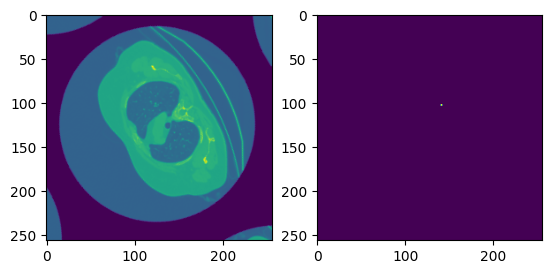

In [25]:
table = {'0': 0, '1': 0}
for x, y in train_loader:
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x[0].T)
    axarr[1].imshow(y[0].T)
    break

In [44]:
def recall_score_(groundtruth_mask, pred_mask):
    intersect = (pred_mask*groundtruth_mask).sum()
    total_pixel_truth = (groundtruth_mask).sum()
    recall = (intersect/total_pixel_truth)
    return recall 

In [77]:
avg_a = 0
avg_b = 0
avg_c = 0
for x, y in train_loader:
    
    with torch.no_grad():
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)
        
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        preds_sq = preds.squeeze(1)
#         print(preds.shape, preds_sq.shape)
#         plt.imshow(preds.cpu()[0].T)
        TP = ((y.cpu() == 1) * (preds_sq.cpu() == 1)).sum()
        TN = ((y.cpu() == 0) * (preds_sq.cpu() == 0)).sum()
        FP = ((y.cpu() == 0) * (preds_sq.cpu() == 1)).sum()
        FN = ((y.cpu() == 1) * (preds_sq.cpu() == 0)).sum()
#         recall_val = recall_score_(y, preds)
#         0.0016678
#         2 * 371 / (2 * 371 + 367056 + 642) = 742 / 368840 = 0.00201
#         print((preds * y).shape, (preds * y).sum(), (preds + y).shape, (preds + y).sum())
        
        dice_score = (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)
        dice_score_a = (2 * TP) / (2 * TP + FP + FN)
        p = dice_score/dice_score_a
        print(dice_score, dice_score_a, p)
        avg_a += dice_score
        avg_b += dice_score_a
        avg_c += p
print(avg_a.item()/len(train_loader), avg_b.item()/len(train_loader), avg_c.item()/len(train_loader))
#         print(x.shape, preds.shape,  y.shape, recall_val, TP, TN, FP, FN, sum([TP, TN, FP, FN]))
#     break

tensor(0.0021, device='cuda:0') tensor(0.0021) tensor(1.0079, device='cuda:0')
tensor(0.0018, device='cuda:0') tensor(0.0025) tensor(0.7352, device='cuda:0')
tensor(0.0020, device='cuda:0') tensor(0.0029) tensor(0.7063, device='cuda:0')
tensor(0.0022, device='cuda:0') tensor(0.0028) tensor(0.7846, device='cuda:0')
tensor(0.0035, device='cuda:0') tensor(0.0035) tensor(0.9960, device='cuda:0')
tensor(0.0024, device='cuda:0') tensor(0.0020) tensor(1.2021, device='cuda:0')
tensor(0.0016, device='cuda:0') tensor(0.0022) tensor(0.7129, device='cuda:0')
tensor(0.0036, device='cuda:0') tensor(0.0041) tensor(0.8601, device='cuda:0')
tensor(0.0039, device='cuda:0') tensor(0.0058) tensor(0.6827, device='cuda:0')
tensor(0.0020, device='cuda:0') tensor(0.0019) tensor(1.0607, device='cuda:0')
tensor(0.0033, device='cuda:0') tensor(0.0033) tensor(1.0157, device='cuda:0')
tensor(0.0041, device='cuda:0') tensor(0.0058) tensor(0.7118, device='cuda:0')
tensor(0.0010, device='cuda:0') tensor(0.0010) tenso

In [ ]:

    with torch.no_grad():
        for x,y in tqdm(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)